In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models
import captum
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:03<00:00, 50812922.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('models/cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), 'models/cifar_torchvision.pt')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1,  2000] loss: 2.162
[1,  4000] loss: 1.857
[1,  6000] loss: 1.688
[1,  8000] loss: 1.589
[1, 10000] loss: 1.503
[1, 12000] loss: 1.467


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[2,  2000] loss: 1.399
[2,  4000] loss: 1.375
[2,  6000] loss: 1.320
[2,  8000] loss: 1.311
[2, 10000] loss: 1.300
[2, 12000] loss: 1.278
[3,  2000] loss: 1.205
[3,  4000] loss: 1.197
[3,  6000] loss: 1.206
[3,  8000] loss: 1.208
[3, 10000] loss: 1.165
[3, 12000] loss: 1.181
[4,  2000] loss: 1.114
[4,  4000] loss: 1.094
[4,  6000] loss: 1.124
[4,  8000] loss: 1.101
[4, 10000] loss: 1.098
[4, 12000] loss: 1.115
[5,  2000] loss: 1.024
[5,  4000] loss: 1.045
[5,  6000] loss: 1.029
[5,  8000] loss: 1.053
[5, 10000] loss: 1.019
[5, 12000] loss: 1.034
Finished Training


In [ ]:
ind = 3

input = inputs[ind].unsqueeze(0)
input.requires_grad = True

In [ ]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )

    return tensor_attributions


In [ ]:
saliency = Saliency(net)
print(type(saliency),saliency)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

<class 'captum.attr._core.saliency.Saliency'> <captum.attr._core.saliency.Saliency object at 0x7e90feacc940>


In [ ]:
ig = IntegratedGradients(net)
print("ig",ig)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
print("Attr_ig",attr_ig,"****",delta)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))


ig <captum.attr._core.integrated_gradients.IntegratedGradients object at 0x7e90feacff40>
Attr_ig tensor([[[[-4.9202e-05, -6.6697e-05, -3.7987e-04,  ...,  1.8259e-04,
            2.5137e-04, -0.0000e+00],
          [-1.6080e-05, -3.2280e-04, -5.2225e-04,  ..., -1.1574e-05,
            1.1264e-03,  3.5798e-04],
          [-5.6600e-06,  3.0128e-05, -2.0123e-05,  ...,  6.7484e-04,
            1.0266e-03,  4.1976e-04],
          ...,
          [ 2.1638e-03,  1.0672e-02,  1.0761e-02,  ...,  1.0746e-02,
           -2.3026e-04,  5.1015e-03],
          [ 1.0464e-03,  3.6303e-03,  5.4225e-03,  ...,  3.8134e-03,
            3.6428e-03,  5.2025e-03],
          [-9.3986e-04, -3.0657e-03, -1.0109e-03,  ...,  1.1770e-03,
           -7.3757e-05, -7.0191e-05]],

         [[-4.2483e-04, -1.8467e-03, -8.6464e-04,  ..., -5.1335e-07,
            9.1984e-05, -0.0000e+00],
          [-3.8427e-04, -8.9173e-05, -9.1376e-04,  ..., -3.4837e-04,
           -1.6062e-04,  1.0658e-04],
          [-2.5166e-04, -3.984

In [ ]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
print("nt",nt)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
print(attr_ig_nt)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
print("transpose",attr_ig_nt)

nt <captum.attr._core.noise_tunnel.NoiseTunnel object at 0x7e90feacf790>
tensor([[[[1.3225e-07, 4.6010e-07, 1.2796e-06,  ..., 6.2026e-07,
           7.3388e-07, 5.2581e-07],
          [9.8438e-07, 1.8606e-06, 1.3254e-05,  ..., 9.0183e-06,
           5.7124e-06, 3.5270e-06],
          [3.0233e-06, 3.4704e-06, 1.4794e-05,  ..., 2.1300e-05,
           1.0594e-05, 3.3297e-06],
          ...,
          [1.7654e-05, 8.3231e-05, 3.4046e-04,  ..., 1.6049e-04,
           2.8094e-05, 1.9606e-05],
          [4.4524e-06, 3.1083e-05, 8.5036e-05,  ..., 3.2194e-05,
           1.1489e-05, 1.8182e-05],
          [1.8937e-06, 7.8037e-06, 6.3561e-06,  ..., 5.5079e-06,
           4.7178e-06, 2.4105e-06]],

         [[1.4964e-06, 1.2485e-06, 3.6443e-06,  ..., 8.0792e-07,
           4.4953e-07, 2.3079e-07],
          [2.1052e-06, 6.2371e-06, 1.4436e-05,  ..., 2.2732e-06,
           5.5584e-07, 7.5276e-07],
          [1.6050e-06, 1.2171e-05, 3.2293e-05,  ..., 3.7719e-06,
           1.6893e-06, 1.5471e-06],
 

In [ ]:
dl = DeepLift(net)
print(dl)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
print(attr_dl)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

tensor([[[[-6.1279e-05, -8.8106e-05, -4.0227e-04,  ...,  2.0319e-05,
           -5.7443e-06, -0.0000e+00],
          [-2.0027e-05, -3.3794e-04, -5.3231e-04,  ...,  3.1477e-04,
            3.6362e-04,  2.4409e-04],
          [-7.0493e-06,  2.5372e-05, -1.9750e-05,  ...,  1.5836e-04,
            3.0250e-04,  2.8622e-04],
          ...,
          [-1.2498e-03,  1.4858e-03,  2.3519e-03,  ..., -1.6977e-04,
            1.0986e-03, -3.7087e-04],
          [ 2.6638e-05,  7.1562e-05,  2.5760e-03,  ...,  3.2843e-04,
            4.1838e-05,  1.9625e-05],
          [-2.3463e-05, -7.4335e-05,  1.0285e-03,  ...,  1.2889e-04,
           -7.5027e-07, -7.1399e-07]],

         [[-5.2911e-04, -1.9869e-03, -9.6601e-04,  ...,  7.4946e-06,
            9.0140e-06, -0.0000e+00],
          [-4.7859e-04, -1.2088e-04, -1.0087e-03,  ..., -1.9370e-04,
           -4.3340e-05,  7.2670e-05],
          [-3.1343e-04, -3.5803e-04,  1.4748e-03,  ...,  1.4851e-04,
            9.5765e-05,  6.3957e-05],
          ...,
     

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [ ]:
import torch

# Assuming attr_dl is your gradient tensor
attr_dl_tensor = torch.tensor(attr_dl)  # Convert NumPy array to PyTorch tensor
old_noise_multiplier=1.3
mean_grad = torch.mean(attr_dl_tensor)

# Update the noise multiplier based on the mean gradient
# You may need to adjust this update rule based on your specific requirements
new_noise_multiplier = old_noise_multiplier * mean_grad

print(new_noise_multiplier)
# Use the new noise multiplier in your Differential Privacy GAN training


tensor(0.0005)


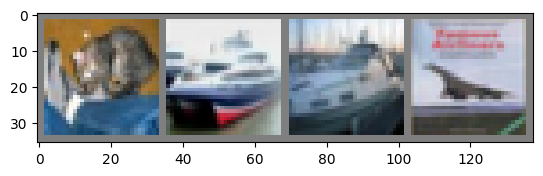

GroundTruth:    cat  ship  ship plane
Predicted:    cat plane plane plane


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Iterate over the testloader using a for loop
for images, labels in testloader:
    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))
    break  # Break the loop after the first iteration if you only want to visualize one batch


Original Image
Predicted: plane  Probability: 0.7117944955825806


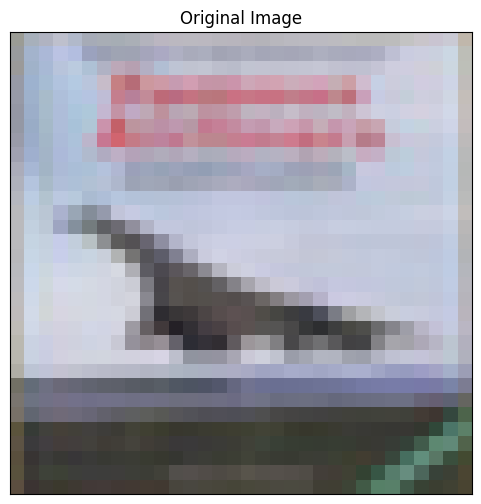

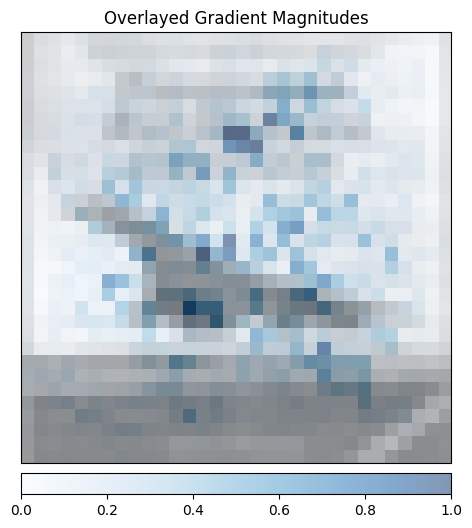

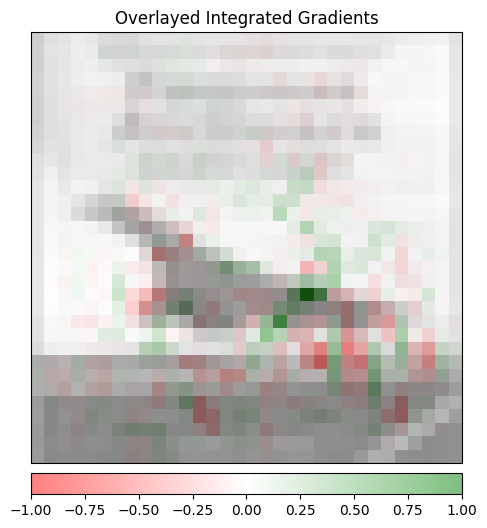

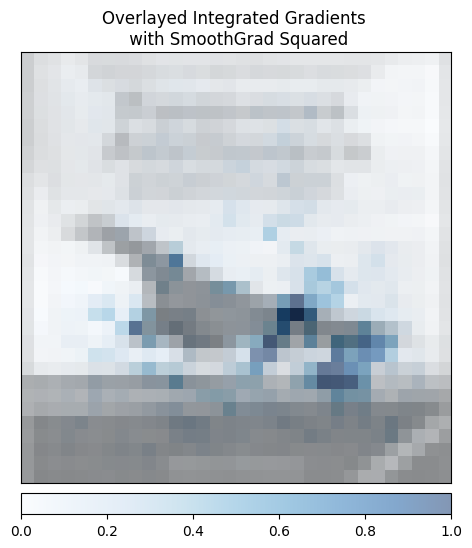

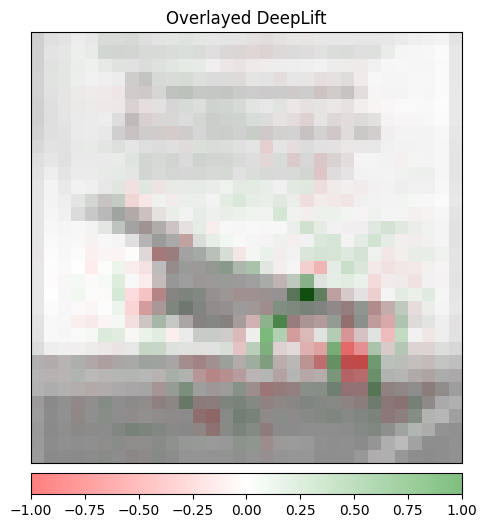

In [ ]:
print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")



In [ ]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [ ]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )

    return tensor_attributions


In [ ]:
saliency = Saliency(net)
print(type(saliency),saliency)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

<class 'captum.attr._core.saliency.Saliency'> <captum.attr._core.saliency.Saliency object at 0x7e90feacde70>


In [ ]:
ig = IntegratedGradients(net)
print("ig",ig)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
print("Attr_ig",attr_ig,"****",delta)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))


ig <captum.attr._core.integrated_gradients.IntegratedGradients object at 0x7e90fe97a230>
Attr_ig tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.2463e-04,
           -5.0792e-06,  0.0000e+00],
          [-6.0150e-05, -2.6626e-04, -7.9194e-04,  ..., -1.9328e-04,
           -3.2656e-04,  0.0000e+00],
          [-9.3718e-05, -1.3491e-03, -1.7690e-03,  ..., -3.8180e-04,
           -3.2593e-04,  0.0000e+00],
          ...,
          [ 8.3053e-03, -2.0702e-02, -2.1479e-02,  ...,  3.2874e-03,
            1.5430e-03, -0.0000e+00],
          [ 4.0129e-03, -1.1184e-02, -1.4200e-02,  ...,  1.5882e-03,
           -1.3651e-04, -0.0000e+00],
          [ 4.0953e-04, -2.2926e-03, -4.5350e-04,  ..., -1.3283e-04,
            2.5981e-04, -0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.2082e-04,
           -1.9917e-04,  0.0000e+00],
          [-2.2571e-04, -1.8465e-03, -1.5562e-03,  ..., -2.1092e-05,
            2.4025e-05,  0.0000e+00],
          [-4.3259e-04, -2.039

In [ ]:
dl = DeepLift(net)
print(dl)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
print(attr_dl)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-6.4560e-06, -5.9156e-05, -3.2780e-04,  ...,  1.0169e-05,
            0.0000e+00,  0.0000e+00],
          [-1.5255e-05, -5.0439e-04, -7.6653e-04,  ...,  2.4485e-04,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 6.0335e-03, -5.8554e-03, -6.3186e-03,  ...,  3.3035e-03,
            1.4356e-03, -0.0000e+00],
          [ 2.6164e-03, -2.8895e-03, -3.3976e-03,  ...,  2.5473e-03,
            2.6593e-04, -0.0000e+00],
          [ 3.5881e-05, -9.3574e-04, -1.2574e-03,  ...,  4.1961e-04,
            3.8112e-04, -0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-2.4226e-05, -6.7281e-04, -5.7735e-04,  ..., -1.3775e-05,
            0.0000e+00,  0.0000e+00],
          [-6.3852e-05, -7.1415e-04,  1.9634e-05,  ..., -2.9896e-04,
            0.0000e+00,  0.0000e+00],
          ...,
     

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from captum.attr import IntegratedGradients, NoiseTunnel, DeepLift, Saliency

# Assuming net is defined somewhere in your code

# Load CIFAR10 dataset and create data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Initialize attribution methods
saliency = Saliency(net)
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
dl = DeepLift(net)

# Initialize accumulators for each attribution method
total_saliency = 0
total_ig = 0
total_nt = 0
total_dl = 0
num_samples = 0

# Loop through the training set
for images, labels in trainloader:
    # Iterate over each image in the batch
    for ind in range(len(images)):
        # if num_samples >= 500:
            # break  # Break out of the loop once 100 images are processed
        num_samples += 1
        print("num_samples",num_samples)

        input = images[ind].unsqueeze(0)
        input.requires_grad = True

        # Compute attributions for each method
        target_label = labels[ind].item()  # Get target label for the current image
        grads = saliency.attribute(input, target=target_label)
        attr_ig, delta = ig.attribute(input, target=target_label, baselines=input * 0, return_convergence_delta=True)
        # print("attr_ig",attr_ig)
        attr_nt = nt.attribute(input, target=target_label, baselines=input * 0, nt_type='smoothgrad_sq', nt_samples=100, stdevs=0.2)
        # print("attr_nt",attr_nt)
        attr_dl = dl.attribute(input, target=target_label, baselines=input * 0)
        # print("attr_dl",attr_dl)

        # Accumulate attributions
        total_saliency += grads.squeeze().cpu().detach().numpy()
        total_ig += attr_ig.squeeze().cpu().detach().numpy()
        total_nt += attr_nt.squeeze().cpu().detach().numpy()
        total_dl += attr_dl.squeeze().cpu().detach().numpy()

    # if num_samples >= 500:
    #     break  # Break out of the outer loop once 100 images are processed

# Compute mean attributions
mean_saliency = total_saliency / num_samples
mean_ig = total_ig / num_samples
mean_nt = total_nt / num_samples
mean_dl = total_dl / num_samples

# Print or use mean attributions as needed
print("Mean Saliency:", mean_saliency)
print("Mean Integrated Gradients:", mean_ig)
print("Mean Noise Tunnel:", mean_nt)
print("Mean Deep Lift:", mean_dl)


num_samples 1
num_samples 2
num_samples 3
num_samples 4
num_samples 5
num_samples 6
num_samples 7
num_samples 8
num_samples 9
num_samples 10
num_samples 11
num_samples 12
num_samples 13
num_samples 14
num_samples 15
num_samples 16
num_samples 17
num_samples 18
num_samples 19
num_samples 20
num_samples 21
num_samples 22
num_samples 23
num_samples 24
num_samples 25
num_samples 26
num_samples 27
num_samples 28
num_samples 29
num_samples 30
num_samples 31
num_samples 32
num_samples 33
num_samples 34
num_samples 35
num_samples 36
num_samples 37
num_samples 38
num_samples 39
num_samples 40
num_samples 41
num_samples 42
num_samples 43
num_samples 44
num_samples 45
num_samples 46
num_samples 47
num_samples 48
num_samples 49
num_samples 50
num_samples 51
num_samples 52
num_samples 53
num_samples 54
num_samples 55
num_samples 56
num_samples 57
num_samples 58
num_samples 59
num_samples 60
num_samples 61
num_samples 62
num_samples 63
num_samples 64
num_samples 65
num_samples 66
num_samples 67
num_

In [ ]:
# Compute the overall mean saliency across all pixels and channels
overall_mean_saliency = np.mean(mean_saliency)
print("Overall Mean Saliency:", overall_mean_saliency)
print("Overall Mean Ig:",np.mean(mean_ig))
print("Overall Mean nt:",np.mean(mean_nt))
print("Overall Mean dl:",np.mean(mean_dl))

In [ ]:
import numpy as np

# Calculate the square of the difference for each attribution method
saliency_diff = np.square(np.max(mean_saliency) - np.min(mean_saliency))
nt_diff = np.square(np.max(mean_nt) - np.min(mean_nt))
ig_diff = np.square(np.max(mean_ig) - np.min(mean_ig))
dl_diff = np.square(np.max(mean_dl) - np.min(mean_dl))

# Print or use the differences as needed
print("Square of the difference in Saliency:", saliency_diff)
print("Square of the difference in Integrated Gradients:", ig_diff)
print("Square of the difference in Noise Tunnel:", nt_diff)
print("Square of the difference in Deep Lift:", dl_diff)
